<a id='top'></a><a name='top'></a>
# Chapter 3: Math with words (TF-IDF vectors)

**Transforming text data from discrete integers to continuous vector representations.**

We want to know which words are more important to a particular document and across the corpus as a whole. Then you can use the "importance" value to find relevant documents in a corpus based on keyword importance within each document.

We turn the words of chapter 2 into continuous numbers rather than just integers representing word counts or binary "bit vectors" that detect the presence or absence of particular words. With representations of words in a continuous space, you can operate on their representation with more exciting math.

In this chapter, we look at three increasingly powerful ways to represent words and their importance in a document:

* Bags of words — Vectors of word counts or frequencies
* Bags of n-grams — Counts of word pairs (bigrams), triplets (trigrams), and so on
* TF-IDF vectors — Word scores that better represent their importance


These are all statistical models in that they are frequency based. They search for linear patterns in word relationships. These "shallow" NLP machines are powerful and useful for many practical applications such as spam filtering and sentiment analysis.

* [Introduction](#introduction)
* [3.0 Imports and Setup](#3.0)
* [3.1 Bag of words](#3.1)
* [3.2 Vectorizing](#3.2)
     - [3.2.1 Vector spaces](#3.2.1)
* [3.3 Zipf's Law](#3.3)
* [3.4 Topic modeling](#3.4)
    - [3.4.1 Return of Zipf](#3.4.1)
    - [3.4.2 Relevance ranking](#3.4.2)
    - [3.4.3 Tools](#3.4.3)
    - [3.4.4 Alternatives](#3.4.4)
    - [3.4.5 Okapi BM25](#3.4.5)
    - [3.4.6 What's next](#3.4.6)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* Wikipedia Kite Article: [script](#kite.html), [source](https://en.wikipedia.org/wiki/Kite)

### Explore

* Counting words and term frequencies to analyze meaning.
* Predicting word occurrence probabilities with Zipf's Law.
* Vector representation of words and how to start using them.
* Finding relevant documents from a corpus using inverse document frequencies.
* Estimating the similarity of pairs of documents with cosine similarity and Okapi BM25

### Key points

* Any web-scale search engine with millisecond response times has the power of a TF-IDF term document matrix hidden under the hood.
* Term frequencies must be weighted by their inverse document frequency to ensure the most important, most meaningful words are given the heft they deserve.
* Zipf's law can help you predict the frequencies of all sorts of things, including words, characters, and people.
* The rows of a TF-IDF term document matrix can be used as a vector representation of the meanings of those individual words to create a vector space model of word semantics.
* Euclidean distance and similarity between pairs of high dimensional vectors doesn't adequately represent their similarity for most NLP applications.
* Cosine distance, the amount of "overlap" between vectors, can be calculated efficiently by just multiplying the elements of normalized vectors together and summing up those products.
* Cosine distance is the go-to similarity score for most natural language vector representations.

---
<a name='3.0'></a><a id='3.0'></a>
# 3.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_03.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
scrapy
vaderSentiment
watermark

Overwriting setup/requirements_03.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
# if IS_COLAB:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [59]:
%%writefile setup/chp03_imports.py
import copy
import locale
import math
import pprint
import random
import re
import warnings
from collections import Counter
from collections import OrderedDict

import nltk
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import brown
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp03_imports.py


In [7]:
!isort setup/chp03_imports.py --sl
!cat setup/chp03_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp03_imports.py
import copy
import locale
import math
import pprint
import random
import re
import warnings
from collections import Counter
from collections import OrderedDict

import nltk
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import brown
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark


In [60]:
import copy
import locale
import math
import pprint
import random
import re
import warnings
from collections import Counter
from collections import OrderedDict

import nltk
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import brown
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(23)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

sys     : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
nltk    : 3.8
seaborn : 0.12.1
re      : 2.2.1
requests: 2.28.1
pandas  : 1.5.3



In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/gb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
<a name='3.1'></a><a id='3.1'></a>
# 3.1 Bag of Words
<a href="#top">[back to top]</a>

Problem: We have a use case where we can disregard grammar and word order, and focus mainly on multiplicity (set properties). 

Idea: Use a *Bag of words* model to represent words and their importance in a document. This creates vectors of word counts of frequences. Bag of words is useful mainly as a method of document classification where the occurrence of each word is used as a feature for training a classifier.

In [11]:
sentence = """The faster Harry got to the store, the faster Harry, the faster, would get home."""
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(sentence.lower())
tokens

['the',
 'faster',
 'harry',
 'got',
 'to',
 'the',
 'store',
 ',',
 'the',
 'faster',
 'harry',
 ',',
 'the',
 'faster',
 ',',
 'would',
 'get',
 'home',
 '.']

---
Get the unique words from the document and their counts. Because you want to count the words as well, we will use `Counter`.

In [12]:
# Dict subclass for counting hashable items.
bag_of_words = Counter(tokens)
bag_of_words

Counter({'the': 4,
         'faster': 3,
         'harry': 2,
         'got': 1,
         'to': 1,
         'store': 1,
         ',': 3,
         'would': 1,
         'get': 1,
         'home': 1,
         '.': 1})

In [13]:
for x in bag_of_words.most_common(4):
    print(x)

('the', 4)
('faster', 3)
(',', 3)
('harry', 2)


---
The number of times a word occurs in a given document is called the *term frequency*, commonly abbreviated TF. 

Calculate the *term frequency* of "harry" from the Counter object (bag_of_words).

In [14]:
times_harry_appears = bag_of_words['harry']

# Number of unique tokens from the original source
num_unique_words = len(bag_of_words)

In [15]:
tf = times_harry_appears / num_unique_words
round(tf, 4)

0.1818

### Dataset: Wikipedia kites article

In [16]:
data_kite = 'data/data_kite'
if not os.path.exists(data_kite):
    os.makedirs(data_kite)

<a id='kite.html'></a><a name='kite.html'></a>
### Dataset: kite.html
<a href="#top">[back to top]</a>

In [17]:
url = 'https://en.wikipedia.org/wiki/Kite'

file = url.split("/")[-1] + ".html"
print(file)

r = requests.get(url)

with open(f"{data_kite}/{file}", "w+") as f:
    f.write(r.text)

Kite.html


In [18]:
with open(f"{data_kite}/{file}", "r") as f:
    html = f.read()
    g = re.search(r'<title>(.*)</title>', html, re.MULTILINE|re.DOTALL)
    if g:
        print(g.groups()[0])

Kite - Wikipedia


In [19]:
soup = BeautifulSoup(html, 'html.parser')
kite_text_online = soup.select_one("div.mw-parser-output").text

In [20]:
kite_text_online[:1500]

"Tethered aircraft\nFor other uses, see Kite (disambiguation).\n The Yokaichi Giant Kite Festival is held every July in Higashiomi, Shiga, Japan.[1]  Various kites being flown\n Star-shaped kite above a meadow south of Hockenheim. This sparless, ram-air inflated kite, has a complex bridle formed of many strings attached to the face of the wing.\nA kite is a tethered heavier-than-air or lighter-than-air craft with wing surfaces that react against the air to create lift and drag forces.[2] A kite consists of wings, tethers and anchors. Kites often have a bridle and tail to guide the face of the kite so the wind can lift it.[3] Some kite designs don't need a bridle; box kites can have a single attachment point. A kite may have fixed or moving anchors that can balance the kite. The name is derived from the kite, the hovering bird of prey.[4]\nThe lift that sustains the kite in flight is generated when air moves around the kite's surface, producing low pressure above and high pressure below

In [21]:
tokenizer_online = TreebankWordTokenizer()
tokens_online = tokenizer.tokenize(kite_text_online.lower())
print(f"tokens_online length: {len(tokens_online)}")
HR()

token_counts_online = Counter(tokens_online)
token_counts_online.most_common(10)

tokens_online length: 6721
----------------------------------------


[(',', 312),
 ('the', 296),
 ('kite', 234),
 ('in', 150),
 ('and', 150),
 ('of', 144),
 ('a', 128),
 ('kites', 124),
 ('to', 93),
 ('[', 87)]

### Use a cleaned up article version.

In [22]:
kite_text = """A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react against the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites often have a bridle to guide the face of the kite at the correct angle so the wind can lift it. A kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane for launch, the tether meets the wing at a single point. A kite may have fixed or moving anchors. Untraditionally in technical kiting, a kite consists of tether-set-coupled wing sets; even in technical kiting, though, a wing in the system is still often called the kite.
The lift that sustains the kite in flight is generated when air flows around the kite’s surface, producing low pressure above and high pressure below the wings. The interaction with the wind also generates horizontal drag along the direction of the wind. The resultant force vector from the lift and drag force components is opposed by the tension of one or more of the lines or tethers to which the kite is attached. The anchor point of the kite line may be static or moving (such as the towing of a kite by a running person, boat, free-falling anchors as in paragliders and fugitive parakites or vehicle).
The same principles of fluid flow apply in liquids and kites are also used under water.
A hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting surface is called a kytoon.
Kites have a long and varied history and many different types are flown individually and at festivals worldwide. Kites may be flown for recreation, art or other practical uses. Sport kites can be flown in aerial ballet, sometimes as part of a competition. Power kites are multi-line steerable kites designed to generate large forces which can be used to power activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a new trend snow kiting. Even Man-lifting kites have been made.
"""

In [23]:
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(kite_text.lower())
print(f"tokens length: {len(tokens)}")
HR()

token_counts = Counter(tokens)
token_counts.most_common(10)

tokens length: 361
----------------------------------------


[('the', 26),
 ('a', 20),
 ('kite', 14),
 (',', 14),
 ('and', 10),
 ('of', 10),
 ('kites', 8),
 ('is', 7),
 ('in', 7),
 ('or', 6)]

### Reuse var `tokens`, but eliminate the stop-words

In [24]:
stopwords = nltk.corpus.stopwords.words('english')
tokens = [x for x in tokens if x not in stopwords]
print(f"tokens length: {len(tokens)}")
HR()

kite_counts = Counter(tokens)

kite_counts.most_common(10)

tokens length: 218
----------------------------------------


[('kite', 14),
 (',', 14),
 ('kites', 8),
 ('wing', 5),
 ('lift', 4),
 ('may', 4),
 ('also', 3),
 ('kiting', 3),
 ('flown', 3),
 ('tethered', 2)]

---
<a name='3.2'></a><a id='3.2'></a>
# 3.2 Vectorizing
<a href="#top">[back to top]</a>

Problem: Discrete data structures such as a frequency dictionary are limited in what they can represent mathematically and conceptually.

Idea: Transform discrete representations into continuous vector representations. This enables additional operations such as direction, similarity, difference. This is more graceful way to represent these numbers for mathematical intents.

Here, instead of describing a document in terms of a frequency dictionary, we'll make a vector of those word counts. In Python, this will be a list. This list, or vector, is something you can do math on directly.

In [25]:
document_vector = []
doc_length = len(tokens)
print(f"tokens length: {doc_length}")
HR()

for key, value in kite_counts.most_common():
    document_vector.append(value / doc_length)
    
document_vector[:5]

tokens length: 218
----------------------------------------


[0.06422018348623854,
 0.06422018348623854,
 0.03669724770642202,
 0.022935779816513763,
 0.01834862385321101]

Having one vector for one document isn’t enough. You can grab a couple more documents and make vectors for each of them as well. But the values within each vector need to be relative to something consistent across all the vectors. 

If you’re going to do math on them, they need to represent a position in a common space, relative to something consistent. 

Your vectors need to have the **same origin** and share the same scale, or “units,” on each 
of their dimensions. 

The first step in this process is to normalize the counts by calculating normalized term frequency instead of raw count in the document (as you did in the last section); the second step is to make all the vectors of standard length or dimension.

---
Create a small lexicon from more vectorized corpus.

In [26]:
docs = ["The faster Harry got to the store, the faster and faster Harry would get home."]
docs.append("Harry is hairy and faster than Jill.")
docs.append("Jill is not as hairy as Harry.")

docs

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']

---
Examine the lexicon for this corpus containing three documents.

In [27]:
doc_tokens = []
for doc in docs:
    doc_tokens += [sorted(tokenizer.tokenize(doc.lower()))]
    
len(doc_tokens[0])

17

In [28]:
all_doc_tokens = sum(doc_tokens, [])
len(all_doc_tokens)

33

In [29]:
lexicon = sorted(set(all_doc_tokens))
len(lexicon)

18

Each of your three document vectors will need to have 18 values, even if the docu- ment for that vector doesn’t contain all 18 words in your lexicon. Each token is assigned a "slot" in your vectors corresponding to its position in your lexicon. Some of those token counts in the vector will be zeros.

In [30]:
zero_vector = OrderedDict((token, 0) for token in lexicon)
zero_vector

OrderedDict([(',', 0),
             ('.', 0),
             ('and', 0),
             ('as', 0),
             ('faster', 0),
             ('get', 0),
             ('got', 0),
             ('hairy', 0),
             ('harry', 0),
             ('home', 0),
             ('is', 0),
             ('jill', 0),
             ('not', 0),
             ('store', 0),
             ('than', 0),
             ('the', 0),
             ('to', 0),
             ('would', 0)])

---
Make copies of that base vector, update the values of the vector for each document, and store them in an array.

In [31]:
doc_vectors = []

for doc in docs:
    vec = copy.copy(zero_vector)
    tokens = tokenizer.tokenize(doc.lower())
    token_counts = Counter(tokens)
    for key, value in token_counts.items():
        vec[key] = value / len(lexicon)
    doc_vectors.append(vec)

We have three vectors, one for each document.

In [32]:
for x in doc_vectors:
    pp.pprint(x)
    HR()

OrderedDict([   (',', 0.05555555555555555),
                ('.', 0.05555555555555555),
                ('and', 0.05555555555555555),
                ('as', 0),
                ('faster', 0.16666666666666666),
                ('get', 0.05555555555555555),
                ('got', 0.05555555555555555),
                ('hairy', 0),
                ('harry', 0.1111111111111111),
                ('home', 0.05555555555555555),
                ('is', 0),
                ('jill', 0),
                ('not', 0),
                ('store', 0.05555555555555555),
                ('than', 0),
                ('the', 0.16666666666666666),
                ('to', 0.05555555555555555),
                ('would', 0.05555555555555555)])
----------------------------------------
OrderedDict([   (',', 0),
                ('.', 0.05555555555555555),
                ('and', 0.05555555555555555),
                ('as', 0),
                ('faster', 0.05555555555555555),
                ('get', 0),
            

---
<a name='3.2.1'></a><a id='3.2.1'></a>
## 3.2.1 Vector spaces
<a href="#top">[back to top]</a>

Problem: We need a way to generalize vectors, to allow modeling quantities such as forces and velocity. These have not only magnitude, but also direction.

Idea: Use the concept of **vector spaces**, which is fundamental for linear algebra. Next, the concept of the **matrix** enables computing in vector spaces. This provides a concise way of manipulating and studying system of linear equations. Vector spaces are characterized by their dimension, which specifies the number of independent directions in the space. Two vectors are "similar" if they share similar directions. 

Vectors are the primary building blocks of linear algebra, or vector algebra. They’re an ordered list of numbers, or coordinates, in a vector space. They describe a location or position in that space. Or they can be used to identify a particular direction and magnitude or distance in that space. A space is the collection of all possible vectors that could appear in that space. So a vector with two values would lie in a 2D vector space, a vector with three values in 3D vector space, and so on.

**For a natural language document vector space, the dimensionality of your vector space is the count of the number of distinct words that appear in the entire corpus.**

---
Next, compute cosine similarity in python.

This gives a value for how much the vectors point in the same direction.

A cosine similarity of 1 represents identical normalized vectors that point in exactly the same direction along all dimensions. The vectors may have different lengths or magnitudes, but they point in the same direction. 

The closer a cosine similarity value is to 1, the closer the two vectors are in angle. For NLP document vectors that have a cosine similarity close to 1, you know that the documents are using similar words in similar proportion. So the documents whose document vectors are close to each other are likely talking about the same thing.

A cosine similarity of 0 represents two vectors that share no components. They are orthogonal, perpendicular in all dimensions. For NLP TF vectors, this situation occurs only if the two documents share no words in common. Because these documents use completely different words, they must be talking about completely different things. This doesn’t necessarily mean they have different meanings or topics, just that they use completely different words.

In [33]:
def cosine_sim(vec1, vec2):
    """ Let's convert our dictionaries to lists for easier matching."""
    vec1 = [val for val in vec1.values()]
    vec2 = [val for val in vec2.values()]

    dot_prod = 0
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
        
    mag_1 = math.sqrt(sum([x**2 for x in vec1]))
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))

    return dot_prod / (mag_1 * mag_2)

---
<a name='3.3'></a><a id='3.3'></a>
# 3.3 Zipf's Law
<a href="#top">[back to top]</a>

Problem: How to represent a relation between rank order and frequency of occurrence?

Idea: *Zipf's Law* is a commonly used power-distribution representation. It states that when observations (such as words) are ranked by their frequency, the frequency of a particular observation is inversely proportional to its rank, `Frequency ∝ 1 Rank`. *Zipf's Law* is used to model the size or ranks of randomly chosen objects from certain population types. In general, it's used to show the relative popularity of a small subset of a population. 

Importance: *Zipf's Law* and other power-law probability distributions can represent many commonly occurring patterns, in various fields ranging from the natural world to linguistics.

In [34]:
nltk.download('brown')

# words is a builtin method of the nltk corpus object that gives 
# a list of tokens
print(len(brown.words()))  

[nltk_data] Downloading package brown to /Users/gb/nltk_data...
[nltk_data]   Package brown is already up-to-date!


1161192


In [35]:
brown.words()[:10]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of']

In [36]:
# Part-of-speech tagging
brown.tagged_words()[:5]

[('The', 'AT'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('Grand', 'JJ-TL'),
 ('Jury', 'NN-TL')]

In [37]:
puncs = [',', '.', '--', '-', '!', '?', ':', ';', '``', "''", '(', ')', '[', ']']
word_list = [x.lower() for x in brown.words() if x not in puncs]
print(len(token_counts))
token_counts.most_common(20)

7


[('as', 2),
 ('jill', 1),
 ('is', 1),
 ('not', 1),
 ('hairy', 1),
 ('harry', 1),
 ('.', 1)]

In [38]:
# Check Zipf's Law
test = pd.DataFrame.from_dict(token_counts, orient='index', columns=['count']).reset_index()
test.head()

,index,count
0,jill,1
1,is,1
2,not,1
3,as,2
4,hairy,1


In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   7 non-null      object
 1   count   7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


The word frequencies in the Brown corpus follow the logarithmic relationship Zipf predicted.

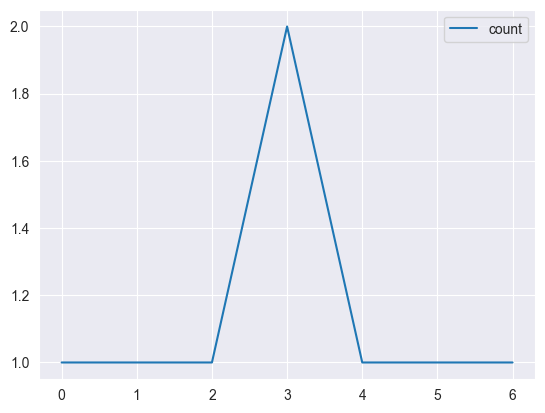

In [40]:
test.plot();

---
<a name='3.4'></a><a id='3.4'></a>
# 3.4 Topic modeling
<a href="#top">[back to top]</a>

Probem: We have a clustering problem, where given a corpus, we want to group together the documents which are topically similar. 

Idea: We can accomplish this in an unsupervised manner via first creating TF-IDF vectors, representing the document over the global vocabulary. Then we use a clustering method over the vector representations of the documents, such as K-means,  hierarchical clustering, etc. 

Importance: We can uncover the latent semantic structure of a corpus in an unsupervised manner, which is very useful. This doesn't require labeling nor training, so it can be a quick way to start analyzing data. Topic models were originally developed as a text-mining tool.

In [41]:
tokenizer = TreebankWordTokenizer()

In [42]:
kite_text = """A kite is traditionally a tethered heavier-than-air craft with wing 
surfaces that react against the air to create lift and drag. A kite consists of 
wings, tethers, and anchors. Kites often have a bridle to guide the face of the 
kite at the correct angle so the wind can lift it. A kite's wing also may be so 
designed so a bridle is not needed; when kiting a sailplane for launch, the tether 
meets the wing at a single point. A kite may have fixed or moving anchors. 
Untraditionally in technical kiting, a kite consists of tether-set-coupled wing sets; 
even in technical kiting, though, a wing in the system is still often called 
the kite. The lift that sustains the kite in flight is generated when air flows 
around the kite's surface, producing low pressure above and high pressure below 
the wings. The interaction with the wind also generates horizontal drag along the 
direction of the wind. The resultant force vector from the lift and drag force 
components is opposed by the tension of one or more of the lines or tethers to 
which the kite is attached. The anchor point of the kite line may be static or 
moving (e.g., the towing of a kite by a running person, boat, free-falling anchors 
as in paragliders and fugitive parakites or vehicle). The same principles of fluid 
flow apply in liquids and kites are also used under water. A hybrid tethered craft 
comprising both a lighter-than-air balloon as well as a kite lifting surface is 
called a kytoon. Kites have a long and varied history and many different types 
are flown individually and at festivals worldwide. Kites may be flown for 
recreation, art or other practical uses. Sport kites can be flown in aerial ballet, 
sometimes as part of a competition. Power kites are multi-line steerable kites 
designed to generate large forces which can be used to power activities such as 
kite surfing, kite landboarding, kite fishing, kite buggying and a new trend 
snow kiting. Even Man-lifting kites have been made."""

kite_text = kite_text.lower()
kite_text_tokens = tokenizer.tokenize(kite_text)
kite_text_tokens_total = len(kite_text_tokens)
kite_text_tokens_total

363

Get the total word count for each document in the corpus, intro_doc and history_doc.

In [43]:
kite_history = """Kites were invented in China, where materials ideal for kite 
building were readily available: silk fabric for sail material; fine, 
high-tensile-strength silk for flying line; and resilient bamboo for a 
strong, lightweight framework. The kite has been claimed as the invention 
of the 5th-century BC Chinese philosophers Mozi (also Mo Di) and Lu Ban 
(also Gongshu Ban). By 549 AD paper kites were certainly being flown, 
as it was recorded that in that year a paper kite was used as a message 
for a rescue mission. Ancient and medieval Chinese sources describe kites 
being used for measuring distances, testing the wind, lifting men, signaling, 
and communication for military operations. The earliest known Chinese kites 
were flat (not bowed) and often rectangular. Later, tailless kites incorporated 
a stabilizing bowline. Kites were decorated with mythological motifs and 
legendary figures; some were fitted with strings and whistles to make musical 
sounds while flying. From China, kites were introduced to Cambodia, Thailand, 
India, Japan, Korea and the western world. After its introduction into India, 
the kite further evolved into the fighter kite, known as the patang in India, 
where thousands are flown every year on festivals such as Makar Sankranti. 
Kites were known throughout Polynesia, as far as New Zealand, with the assumption 
being that the knowledge diffused from China along with the people. 
Anthropomorphic kites made from cloth and wood were used in religious ceremonies 
to send prayers to the gods. Polynesian kite traditions are used by anthropologists 
get an idea of early "primitive" Asian traditions that are believed to have at 
one time existed in Asia."""

kite_history = kite_history.lower()
kite_history_tokens = tokenizer.tokenize(kite_history)
kite_history_tokens_total = len(kite_history_tokens)
kite_history_tokens_total

297

We have created our tokenized kite documents. Now, look at the term frequencies of "kite" in each document. We store the TFs we find in two dictionaries, one for each document.

In [44]:
intro_tf = {}
intro_counts = Counter(kite_text_tokens)
intro_tf['kite'] = intro_counts['kite'] / kite_text_tokens_total

print(f"Term Frequency of 'kite' in intro is {intro_tf['kite']:.4f}")

Term Frequency of 'kite' in intro is 0.0441


In [45]:
history_tf = {}
history_counts = Counter(kite_history_tokens)
history_tf['kite'] = history_counts['kite'] / kite_history_tokens_total

print(f"Term Frequency of 'kite' in history is {history_tf['kite']:.4f}")

Term Frequency of 'kite' in history is 0.0202


In [46]:
intro_tf['and'] = intro_counts['and'] / kite_text_tokens_total
history_tf['and'] = history_counts['and'] / kite_history_tokens_total

print(f"Term Frequency of 'and' in intro is {intro_tf['and']:.4f}")
print(f"Term Frequency of 'and' in history is {history_tf['and']:.4f}")

Term Frequency of 'and' in intro is 0.0275
Term Frequency of 'and' in history is 0.0303


A term's IDF is merely the ratio of the total number of documents to the number of documents the term appears in. In the case of "and" and "kite" in the current example the answer is the same for both.

* 2 total documents / 2 documents contain “and” = 2/2 = 1
* 2 total documents / 2 documents contain “kite” = 2/2 = 1
* Not very interesting. So let’s look at another word “China.”
* 2 total documents / 1 document contains “China” = 2/1 = 2

Next, use this "rarity" measure to weight the term frequencies.

In [47]:
num_docs_containing_and = 0
for doc in [kite_text_tokens, kite_history_tokens]:
    if 'and' in doc:
        num_docs_containing_and += 1

num_docs_containing_and

2

In [48]:
num_docs_containing_kite = 0
for doc in [kite_text_tokens, kite_history_tokens]:
    if 'kite' in doc:
        num_docs_containing_kite += 1
        
num_docs_containing_kite

2

In [49]:
num_docs_containing_china = 0
for doc in [kite_text_tokens, kite_history_tokens]:
    if 'china' in doc:
        num_docs_containing_china += 1
        
num_docs_containing_china

1

In [50]:
# Grab the TF of "China" in the two documents
intro_tf['china'] = intro_counts['china'] / kite_text_tokens_total
history_tf['china'] = history_counts['china'] / kite_history_tokens_total

In [51]:
# Get the TDF for all three. Store the IDFs in dictionaries per document.
num_docs = 2
intro_idf = {}
history_idf = {}

intro_idf['and'] = num_docs / num_docs_containing_and 
history_idf['and'] = num_docs / num_docs_containing_and 

intro_idf['kite'] = num_docs / num_docs_containing_kite 
history_idf['kite'] = num_docs / num_docs_containing_kite 

intro_idf['china'] = num_docs / num_docs_containing_china 
history_idf['china'] = num_docs / num_docs_containing_china 

In [52]:
# Calculate for the intro document
intro_tfidf = {}

intro_tfidf['and'] = intro_tf['and'] * intro_idf['and']
intro_tfidf['kite'] = intro_tf['kite'] * intro_idf['kite']
intro_tfidf['china'] = intro_tf['china'] * intro_idf['china']

print(f"{intro_tfidf['and']:.4f}")
print(f"{intro_tfidf['kite']:.4f}")
print(f"{intro_tfidf['china']:.4f}")

0.0275
0.0441
0.0000


In [53]:
# Calculate for the history document
history_tfidf = {}

history_tfidf['and'] = history_tf['and'] * history_idf['and']
history_tfidf['kite'] = history_tf['kite'] * history_idf['kite']
history_tfidf['china'] = history_tf['china'] * history_idf['china']

print(f"{history_tfidf['and']:.4f}")
print(f"{history_tfidf['kite']:.4f}")
print(f"{history_tfidf['china']:.4f}")

0.0303
0.0202
0.0202


---
<a name='3.4.1'></a><a id='3.4.1'></a>
## 3.4.1 Return of Zipf
<a href="#top">[back to top]</a>

Problem: Zipf's Law implies when you compare the frequencies of two words, like "cat" and "dog", even if they occur a similar number of times, the more frequent word will have an exponentially higher frequency than the less frequent one. 

Idea: Scale all the word frequencies (and document frequencies) with the `log()` function. This ensures that words such as "cat" and "dog", which may have similar counts, are not exponentially different in frequency. This log distribution of word frequencies also ensure the TF-IDF scores are more uniformly distributed. 

Importance: Scaling frequencies with log() is used for a proper TF-IDF score.

---
<a name='3.4.2'></a><a id='3.4.2'></a>
## 3.4.2 Relevance ranking
<a href="#top">[back to top]</a>

Problem: Given a query and corpus, we want to determing how relevant each text document is for the given query.

Idea: Use *relevance ranking* algorithms to determine the degree of relevance. This allows the ranking of text documents and actions such as returning the best matching documents for the query.

Importance: *Relevance ranking* is a core problem of Information Retrieval,  playing a fundamental role in real world applications such as search engines. 

In [54]:
# Create a K-dimensional vector representation of each document in the corpus.
doc_0 = "The faster Harry got to the store, the faster Harry, the faster, would get home."
doc_1 = "Harry is hairy and faster than Jill."
doc_2 = "Jill is not as hairy as Harry."

document_tfidf_vectors = []
documents = [doc_0, doc_1, doc_2]

for doc in docs:
    vec = copy.copy(zero_vector)
    tokens = tokenizer.tokenize(doc.lower())
    token_counts = Counter(tokens)
    
    for key, value in token_counts.items():
        docs_containing_key = 0
        for _doc in docs:
            if key in _doc:
                docs_containing_key += 1
        tf = value / len(lexicon)
        if docs_containing_key:
            idf = len(docs) / docs_containing_key
        else:
            idf = 0
        vec[key] = tf * idf
    document_tfidf_vectors.append(vec)

for x in document_tfidf_vectors:
    pp.pprint(x)
    HR()

OrderedDict([   (',', 0.16666666666666666),
                ('.', 0.05555555555555555),
                ('and', 0.08333333333333333),
                ('as', 0),
                ('faster', 0.25),
                ('get', 0.16666666666666666),
                ('got', 0.16666666666666666),
                ('hairy', 0),
                ('harry', 0.0),
                ('home', 0.16666666666666666),
                ('is', 0),
                ('jill', 0),
                ('not', 0),
                ('store', 0.16666666666666666),
                ('than', 0),
                ('the', 0.5),
                ('to', 0.16666666666666666),
                ('would', 0.16666666666666666)])
----------------------------------------
OrderedDict([   (',', 0),
                ('.', 0.05555555555555555),
                ('and', 0.08333333333333333),
                ('as', 0),
                ('faster', 0.08333333333333333),
                ('get', 0),
                ('got', 0),
                ('hairy', 0.08

Now you have all you need to do a basic TF-IDF-based search. You can treat the search query itself as a document, and therefore get the TF-IDF-based vector representation of it. The last step is then to find the documents whose vectors have the highest cosine similarities to the query and return those as the search results.
If you take your three documents about Harry, and make the query "How long does it take to get to the store?"


In [55]:
query = "How long does it take to get to the store?"

# Make sure we are dealing with new objects, not multiple references to the same object
query_vec = copy.copy(zero_vector)  

tokens = tokenizer.tokenize(query.lower())
token_counts = Counter(tokens)

for key, value in token_counts.items():
    docs_containing_key = 0
    for _doc in documents:
        if key in _doc.lower():
            docs_containing_key += 1
    if docs_containing_key == 0:  # We didn't find that token in the lexicon go to next key
        continue
    tf = value / len(tokens)
    idf = len(documents) / docs_containing_key 
    query_vec[key] = tf * idf 

print(f"Document 0: {cosine_sim(query_vec, document_tfidf_vectors[0]):.4f}")
print(f"Document 1: {cosine_sim(query_vec, document_tfidf_vectors[1]):.4f}")
print(f"Document 2: {cosine_sim(query_vec, document_tfidf_vectors[2]):.4f}")

Document 0: 0.6133
Document 1: 0.0000
Document 2: 0.0000


* Three documents: doc_0, doc_1, doc_2
* Query: "How long does it take to get to the store?"
* Result: document 0 has the most relevance for this query.

<a name='3.4.3'></a><a id='3.4.3'></a>
## 3.4.3 Tools
<a href="#top">[back to top]</a>

Problem: Use a library to quickly build a TF-IDF matrix.

Idea: Use the sklearn library's TF-IDF class.  

---

API Notes:

* [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

Using the scikit-learn library, we create a matrix for the three documents and the inverse document frequency for each term in the lexicon. We have a matrix (a list of Python lists) that represents the three documents (the three rows of the matrix). The TF-IDF of each term, token, or word in the lexicon make up the columns of the matrix (here, the indices of each row). They only have 16, as they tokenize differently and drop the punctuation. 

In [56]:
corpus = docs
vectorizer = TfidfVectorizer(min_df=1)

# The TFIDFVectorizer model produces a sparse numpy matrix, because a 
# TF-IDF matrix usually contains mostly zeros, since most documents 
# use a small portion of the total words in the vocabulary.
model = vectorizer.fit_transform(corpus)

# The model becomes a sparse numpy matrix, as in a large corpus there 
# would be mostly zeros to deal with. todense() brings it back to a 
# regular numpy matrix for easier viewing.
print(model.todense().round(1))
HR()
print(model)

[[0.2 0.  0.5 0.2 0.2 0.  0.3 0.2 0.  0.  0.  0.2 0.  0.6 0.2 0.2]
 [0.4 0.  0.4 0.  0.  0.4 0.3 0.  0.4 0.4 0.  0.  0.5 0.  0.  0. ]
 [0.  0.8 0.  0.  0.  0.3 0.2 0.  0.3 0.3 0.4 0.  0.  0.  0.  0. ]]
----------------------------------------
  (0, 7)	0.21233717847222938
  (0, 3)	0.21233717847222938
  (0, 15)	0.21233717847222938
  (0, 0)	0.1614878973151404
  (0, 11)	0.21233717847222938
  (0, 14)	0.21233717847222938
  (0, 4)	0.21233717847222938
  (0, 6)	0.25081951635416216
  (0, 2)	0.48446369194542127
  (0, 13)	0.6370115354166881
  (1, 9)	0.36930805406135764
  (1, 12)	0.4855957102062416
  (1, 5)	0.36930805406135764
  (1, 8)	0.36930805406135764
  (1, 0)	0.36930805406135764
  (1, 6)	0.28680064898176716
  (1, 2)	0.36930805406135764
  (2, 1)	0.7514324226348535
  (2, 10)	0.3757162113174268
  (2, 9)	0.28574186296253085
  (2, 5)	0.28574186296253085
  (2, 8)	0.28574186296253085
  (2, 6)	0.221904046872743


In [57]:
print(vectorizer.get_feature_names_out())
HR()

x = model.toarray()
x = list(map(lambda x :str(x) + '%', x.round(1)))
print(x)

['and' 'as' 'faster' 'get' 'got' 'hairy' 'harry' 'home' 'is' 'jill' 'not'
 'store' 'than' 'the' 'to' 'would']
----------------------------------------
['[0.2 0.  0.5 0.2 0.2 0.  0.3 0.2 0.  0.  0.  0.2 0.  0.6 0.2 0.2]%', '[0.4 0.  0.4 0.  0.  0.4 0.3 0.  0.4 0.4 0.  0.  0.5 0.  0.  0. ]%', '[0.  0.8 0.  0.  0.  0.3 0.2 0.  0.3 0.3 0.4 0.  0.  0.  0.  0. ]%']


In [58]:
corpus = [doc_0]
vectorizer = TfidfVectorizer(min_df=1)

# The TFIDFVectorizer model produces a sparse numpy matrix, because a 
# TF-IDF matrix usually contains mostly zeros, since most documents 
# use a small portion of the total words in the vocabulary.
model = vectorizer.fit_transform(corpus)

# The model becomes a sparse numpy matrix, as in a large corpus there 
# would be mostly zeros to deal with. todense() brings it back to a 
# regular numpy matrix for easier viewing.
print(model.todense().round(1))
HR()
print(model)


[[0.5 0.2 0.2 0.3 0.2 0.2 0.7 0.2 0.2]]
----------------------------------------
  (0, 4)	0.1690308509457033
  (0, 1)	0.1690308509457033
  (0, 8)	0.1690308509457033
  (0, 5)	0.1690308509457033
  (0, 7)	0.1690308509457033
  (0, 2)	0.1690308509457033
  (0, 3)	0.3380617018914066
  (0, 0)	0.50709255283711
  (0, 6)	0.6761234037828132


<a name='3.4.4'></a><a id='3.4.4'></a>
## 3.4.4 Alternatives
<a href="#top">[back to top]</a>

Problem: What are the various ways to normalize and smooth frequency weights?

Idea: TF-IDF, TF-ICF, Okapi BM25, ATC, LTU, MI, PosMI, T-Test, x², Lin98a, Lin98b, Gref94

<a name='3.4.5'></a><a id='3.4.5'></a>
## 3.4.5 Okapi BM25
<a href="#top">[back to top]</a>

Problem: Create a scoring function that goes beyond rewarding term frequency and penalizing document frequency, and also account for document length and term frequency saturation. 

Idea: The *Okapi BM25* bag-of-words retrieval function ranks a set of documents based on the query terms appearing in each document, regardless of their proximity in within the document. This does not just compute the TF-IDF cosine similarity, it normalizes and smooths the similarity. It also ignores duplicate terms in the query document, clipping the term frequencies for the query vector at 1.

<a name='3.4.6'></a><a id='3.4.6'></a>
## 3.4.6 What's Next
<a href="#top">[back to top]</a>

Problem: What is the next step after converting natural language text to numbers?

Idea: We can begin to manipulate and compute with them, refining those numbers to represent the meaning or topic of natural language text.